<a href="https://colab.research.google.com/github/emuanel/Voice-Pathology-Detection/blob/main/melspec_CNN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
import librosa
import glob 
import numpy as np
from keras.layers import Dense, Input, Conv2D, MaxPooling2D, Flatten, Dropout
from keras.models import Sequential
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sn
from statistics import mean, median

DATA: Saarbruecken Voice Database

http://stimmdb.coli.uni-saarland.de/

In [ ]:
pathological_dir = "/content/drive/MyDrive/projektySem2Mgr/IUI/data/pathological/"
pathological_paths = glob.glob(pathological_dir+"*.wav")

healthy_dir = "/content/drive/MyDrive/projektySem2Mgr/IUI/data/healthy/"
healthy_paths = glob.glob(healthy_dir+"*.wav")

X = []
y = []

for pathological in pathological_paths:
    X.append(librosa.load(pathological))
    y.append(1)
    
for healthy in healthy_paths:
    X.append(librosa.load(healthy))
    y.append(0)

In [ ]:
def melspectrogram(y, sr):
    return librosa.feature.melspectrogram(y=y, sr=sr)

spectrograms = []

for signal in X:
    spectrograms.append(melspectrogram(signal[0], signal[1]))

lenghts = []
for i in spectrograms:
    lenghts.append(i.shape[1])
lenght = int(median(lenghts))

for i in range(len(spectrograms)):
    if spectrograms[i].shape[1] > lenght:
        spectrograms[i] = spectrograms[i][:, :lenght]
    elif spectrograms[i].shape[1] < lenght:
        columns = lenght-spectrograms[i].shape[1]
        rows = spectrograms[i].shape[0]
        spectrograms[i] = np.c_[spectrograms[i], np.zeros((rows, columns))]
    spectrograms[i] = np.expand_dims(spectrograms[i], axis=2)    
 
X_spec = np.array(spectrograms)

In [ ]:
input_shape = (X_spec.shape[1], X_spec.shape[2], 1)

model = Sequential([
    Input(shape=input_shape),                   
    Conv2D(48, kernel_size=2, activation='relu', padding='SAME'),
    Dropout(0.2),
    MaxPooling2D(pool_size=(2,2)),

    Conv2D(64, kernel_size=3, activation='relu', padding='SAME'),
    Dropout(0.2),
    MaxPooling2D(pool_size=(2,2)),

    Conv2D(128, kernel_size=3, activation='relu', padding='SAME'),
    Dropout(0.2),
    MaxPooling2D(pool_size=(2,2)),
   
    Flatten(),          
    #tf.keras.layers.BatchNormalization(axis=1),
    Dense(256, activation='relu'),
    Dense(1, activation='sigmoid') 
    ])
model.compile(optimizer='adam', loss='binary_crossentropy', metrics='accuracy')

X_train, X_test, y_train, y_test = train_test_split(X_spec, np.array(y), test_size=0.3, random_state=42)
x_valid, X_test, y_valid, y_test = train_test_split(X_test, y_test, test_size=0.5, random_state=42)

batch_size=16
epochs=10
history = model.fit(X_train, y_train, batch_size=batch_size, epochs=epochs, validation_data=(x_valid, y_valid))

print(model.summary())

Epoch 1/10
67/67 [==============================] - 3s 38ms/step - loss: 4.2763 - accuracy: 0.6289 - val_loss: 0.6595 - val_accuracy: 0.6784
Epoch 2/10
67/67 [==============================] - 2s 33ms/step - loss: 0.6650 - accuracy: 0.7280 - val_loss: 0.6251 - val_accuracy: 0.6828
Epoch 3/10
67/67 [==============================] - 2s 33ms/step - loss: 0.6525 - accuracy: 0.7148 - val_loss: 0.6958 - val_accuracy: 0.6608
Epoch 4/10
67/67 [==============================] - 2s 33ms/step - loss: 0.5444 - accuracy: 0.7488 - val_loss: 0.7486 - val_accuracy: 0.6652
Epoch 5/10
67/67 [==============================] - 2s 33ms/step - loss: 0.4906 - accuracy: 0.7677 - val_loss: 0.5853 - val_accuracy: 0.6608
Epoch 6/10
67/67 [==============================] - 2s 33ms/step - loss: 0.4376 - accuracy: 0.7970 - val_loss: 0.6078 - val_accuracy: 0.7181
Epoch 7/10
67/67 [==============================] - 2s 33ms/step - loss: 0.4416 - accuracy: 0.8187 - val_loss: 0.7016 - val_accuracy: 0.7004
Epoch 8/10
67

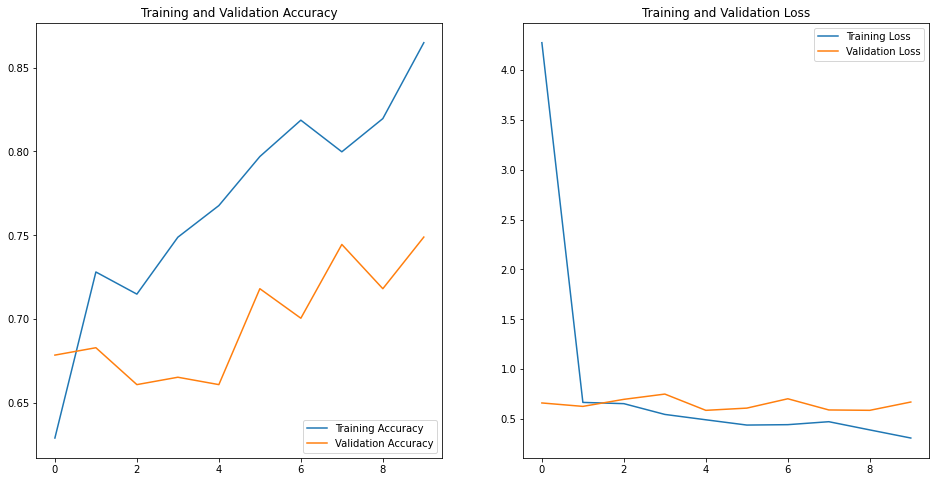

              precision    recall  f1-score   support

           0       0.62      0.64      0.63       103
           1       0.69      0.68      0.69       124

    accuracy                           0.66       227
   macro avg       0.66      0.66      0.66       227
weighted avg       0.66      0.66      0.66       227



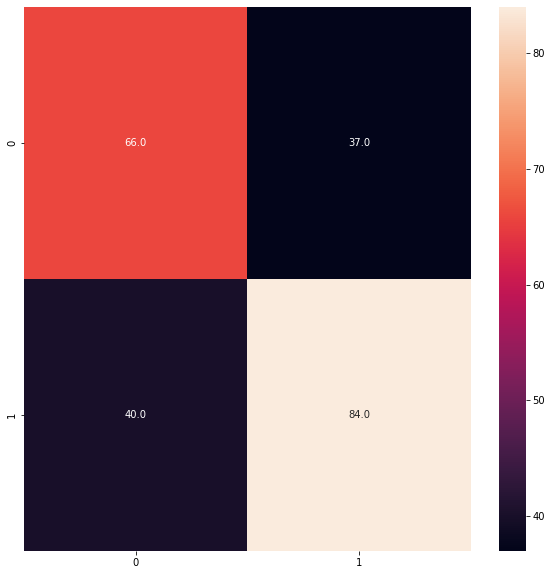

In [ ]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs_range = range(epochs)

plt.figure(figsize=(16, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

y_pred = model.predict(X_test)
y_pred = np.where(y_pred < 0.5, 0, 1)
print(classification_report(y_test, y_pred))

matrix = confusion_matrix(y_test, y_pred)

plt.subplots(figsize=(10,10))  
sn.heatmap(matrix, annot = True, annot_kws={"size": 10}, fmt = '.1f')